<a href="https://colab.research.google.com/github/SaxMan96/Harmony-Analyzer/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install pyRealParser
!pip install pychord

  Created wheel for pyRealParser: filename=pyRealParser-0.1.0-cp36-none-any.whl size=6830 sha256=93dd41bdf744d035ff1573abaee38584d11b8fc1a219007804db59888accb4dc
  Stored in directory: /root/.cache/pip/wheels/5e/9c/44/4d74ebd89107df4c625c81437cad9aa8ee55afb26e251d90fa
Successfully built pyRealParser
  Created wheel for pychord: filename=pychord-0.4.1-py2.py3-none-any.whl size=9935 sha256=90ad4d2800589a3850f633fd0c33ad4a7c738374016997c46c2f9ff59fa52c74
  Stored in directory: /root/.cache/pip/wheels/40/ea/ad/0233db8ea21a1e66c4ea0ead8f3437199f8e5902faa02834f8
Successfully built pychord


In [392]:
import pandas as pd
import numpy as np
import ast
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utilities import *
from music21.harmony import chordSymbolFigureFromChord as figureChord
from music21.chord import Chord

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing import sequence

import warnings

warnings.filterwarnings(action="once")

LSTM requirements:

- The LSTM input layer must be 3D.
- LSTMs don’t like sequences of more than 200-400 time steps, so the data will need to be split into samples.
- If you have a long sequence of thousands of observations, you must split it into samples and then reshape it for your LSTM model.
- The LSTM needs data with the format of [samples, time steps and features].
- The LSTM input layer is defined by the input_shape argument on the first hidden layer.
- The input_shape argument takes a tuple of two values that define the number of time steps and features.
- The number of samples is assumed to be 1 or more.
- The reshape() function on NumPy arrays can be used to reshape your 1D or 2D data to be 3D.
- The reshape() function takes a tuple as an argument that defines the new shape.


In [393]:
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
import utilities as my_utils
# ft = FastText.load("/content/gdrive/My Drive/Google Colab Data/Harmony_Analyzer/embeddings/fastText.model")
ft = FastText.load("./embeddings/fastText.model")
songs = my_utils.build_sentences()

In [394]:
def prep_data(songs, sample_len = 4):
    # Remove too short songs
    songs = [chords for chords in songs if len(chords) > sample_len]
    x = []
    y = []
    for chords in songs:
        for i in range(len(chords)):
            if i < len(chords) - sample_len:
                x.append(chords[i: i + sample_len - 1])
            else:
                x.append(
                    chords[i: len(chords) - 1]
                    + chords[: (i + sample_len) % len(chords)]
                )
            y.append(chords[(i + sample_len) % len(chords)])
    x = np.array(x)
    y = np.array(y)
    print(x.shape, y.shape)
    return x, y

X, y = prep_data(songs)

(1243944, 3) (1243944,)


In [395]:
from tqdm import tqdm_notebook as tqdm
def encode_chords(X, y, model):
    X_embedded = []
    y_embedded = []
    for X_sample, y_sample in tqdm(zip(X, y), total=X.shape[0], desc=str(model).split("(")[0]+' Encoding'):
        X_embedded.append(model.wv[X_sample])
        y_embedded.append(model.wv[y_sample])
    X_embedded = np.array(X_embedded)
    y_embedded = np.array(y_embedded)
    return X_embedded, y_embedded

X_embedded, y_embedded = encode_chords(X, y, ft)

C:\Users\Mateusz\Miniconda3\envs\tf-gpu-env\lib\site-packages\tqdm\__init__.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  TqdmDeprecationWarning)


In [396]:
print(y_embedded[0])

[-2.8218837   2.6679103   1.1131471  -1.3137835  -0.1720473   0.6520036
  0.5008011  -1.3545598  -1.2499863   0.53334844  0.4341415  -0.02315862
  1.7414213  -0.3618903  -2.1168952   1.6319815  -1.4610413   0.5977253
 -0.45896897  0.80857223  0.89994234  3.2679656   0.75783396 -2.9877284
  0.79341704 -0.14857055 -0.98599106 -0.327897    1.6920537  -0.75195116
 -0.22168867  0.95694226  1.5130386  -1.2832272   0.33268866  1.0442535
 -1.9442675  -1.6550491  -0.05510071 -0.47213438  0.30764127 -0.30558968
 -0.3758615   0.75716263 -1.0502764  -1.1331551   1.2711804  -2.2275395
  2.4989285  -2.1432517   0.85097796  0.2423095   1.6097819   1.6056014
 -1.3808945   1.0785171   0.16974561 -1.024235   -0.44757247  0.03198034
  1.1975018   2.1273863   0.23836027 -2.0223749 ]


In [430]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y_embedded, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
for name, X_set in zip(["Train", "Test", "Valid"],[X_train, X_test, X_val]):
    print(name,":\t", round(X_set.shape[0]/X_embedded.shape[0]*100),X_set.shape, "%", sep="")

Train:	60(746366, 3, 64)%
Test:	20(248789, 3, 64)%
Valid:	20(248789, 3, 64)%


# Test Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Dropout

model = keras.Sequential(
    [
        LSTM(64, input_shape=X_train.shape[1:]),
        Dense(y_train.shape[1], activation='sigmoid')
    ]
)

In [398]:
import tensorflow as tf; print(tf.__version__)

2.0.0


In [429]:
model = Sequential(
    [
        LSTM(128, activation='relu', return_sequences=True, input_shape=X_train.shape[1:]),
        LSTM(128, activation='relu'),
        Dense(y_train.shape[1])
    ]
)
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
Total params: 238,656
Trainable params: 238,656
Non-trainable params: 0
_________________________________________________________________
None


In [400]:
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

class Metrics(Callback):
    def __init__(self, tr_data, val_data):
        self.validation_data = val_data    
        self.train_data = tr_data    
    
    def cosine_distance_sum(self, A, B):
        return sum([1.0 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(A, B)])

    def mean_cos_dist_sum(self, X_vali, y_vali):
        y_pred = model.predict(X_vali)
        return self.cosine_distance_sum(y_pred, y_vali)/y_vali.shape[0]
        
    def on_train_begin(self, logs={}):
        self.mean_cos_dist = []      
        self.val_mean_cos_dist = []       
        
    def on_epoch_end(self, epoch, logs={}):
        score = self.mean_cos_dist_sum(self.train_data[0][:1000], self.train_data[1][:1000])
        score_val = self.mean_cos_dist_sum(self.validation_data[0][:1000], self.validation_data[1][:1000])
        self.mean_cos_dist.append(score)
        self.val_mean_cos_dist.append(score_val)
        print('epoch {},\tloss {:3.4f},\tval_loss {:3.4f}\tmean_cos_dist {:3.4f}\tval_mean_cos_dist {:3.4f}.'.format(
            epoch, logs['loss'], logs['val_loss'], score, score_val))
        
    def on_train_end(self, logs={}):
        self.mean_cos_dist = {'mean_cos_dist': self.mean_cos_dist}    
        self.val_mean_cos_dist = {'val_mean_cos_dist': self.val_mean_cos_dist}      
        
    def get_train_data(self):
        return self.train_data
    
    def get_val_data(self):
        return self.validation_data
    
    
validation_split = 0.25
epochs = 30
batch_size = 5000
loss = Huber() 
optimizer = Adam(lr=1e-3)
metrics = Metrics((X_train, y_train),
                  (X_val, y_val))

METRICS_NAMES = [
        "loss",
        "mean_cos_dist",
    ]
model.compile(loss=loss, optimizer=optimizer)
print(model.summary())
history = model.fit(metrics.get_train_data()[0], 
                    metrics.get_train_data()[1], 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data = metrics.get_val_data(),
                    callbacks=[metrics], 
                    verbose=1).history

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
Total params: 238,656
Trainable params: 238,656
Non-trainable params: 0
_________________________________________________________________
None
Train on 746366 samples, validate on 248789 samples
Epoch 1/30
746366/746366 [==============================] - 10s 14us/sample - loss: 0.5602 - val_loss: 0.5253
Epoch 2/30
746366/746366 [==============================] - 8s 10us/sample - loss: 0.5188 - val_loss: 0.5148
Epoch 3/30
746366/746366 [==============================] - 8s 11us/sample - loss: 0.5117 - val_loss:

In [401]:
import matplotlib.pyplot as plt
def plot_loss(history, metric_name):
    val_loss = history["val_" + metric_name]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name]
    plt.plot(loss, linewidth=3, label="train")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(metric_name)
    plt.show()

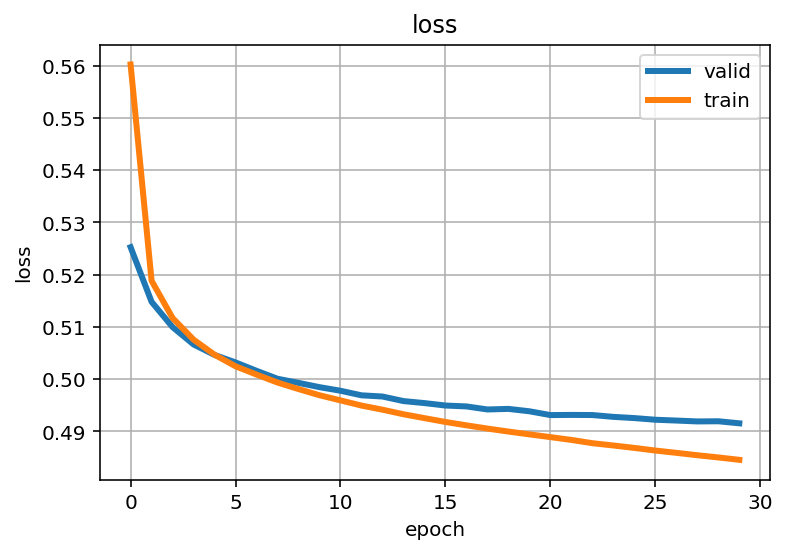

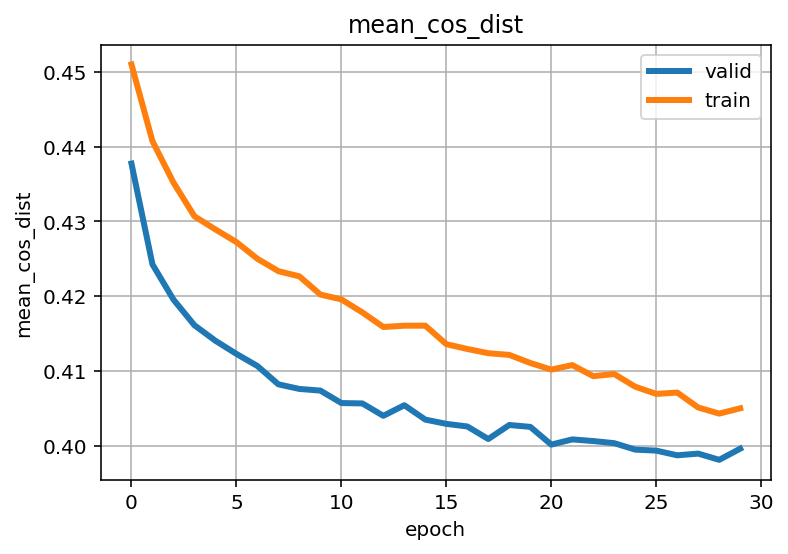

In [402]:
history.update(metrics.mean_cos_dist)
history.update(metrics.val_mean_cos_dist)
for metric_name in METRICS_NAMES:
    plot_loss(history, metric_name)

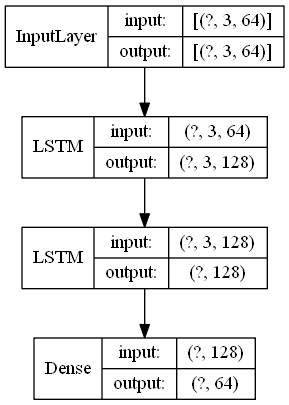

In [428]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(
        model,
        to_file="images/model/LTSTM_30_plot.png",
        show_shapes=True,
        show_layer_names=False,
    )

In [403]:
def save_model(model, model_name):
    model_json = model.to_json()
    with open("models/"+model_name+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("models/"+model_name+".h5")
    print("Saved model to disk")
    
save_model(model, "LSTM_30_epoch")

Saved model to disk


In [404]:
print(X_train[0][0], ft.wv.most_similar(X_train[0][0].reshape(1,-1))[0], sep="\n")

[ 0.2831416   1.9003518  -0.5969981   0.04515171  0.88170296 -1.8052266
 -0.28070796 -0.7344635  -0.5129904   0.5274376  -0.50100714  0.35816643
 -0.50922704 -1.9544994   0.02911769  1.1419986   0.01741598  0.5366339
 -1.4860406   0.5877922  -0.6481257   1.7070045  -0.65793806  1.18562
  0.46790358 -0.45111388  0.16563676 -2.42333    -0.20980245  0.73004264
  0.1077087  -0.0410464  -1.8511068  -0.4033527   0.5019449   1.9654834
 -0.8074281  -0.7183717  -0.638709    1.6402546   1.4586475  -0.3450368
 -0.8329103  -0.53891575 -0.8557045   0.56288075 -0.14011712 -0.19686495
 -1.7863393   0.06247514  0.5551195  -1.4328742   1.5419097  -0.2912826
 -1.1314827   0.41545781 -0.6453534   0.49623677 -0.38735077 -1.5992879
  1.1138496  -1.2525398  -0.26182267 -0.30861476]
('Dbo7', 1.0000001192092896)


In [405]:
X_test[0][np.newaxis, :].shape, X_test[0:1].shape

((1, 3, 64), (1, 3, 64))

In [406]:
y_pred = model.predict(X_val)

In [410]:
X_train[0]

array([[ 0.2831416 ,  1.9003518 , -0.5969981 ,  0.04515171,  0.88170296,
        -1.8052266 , -0.28070796, -0.7344635 , -0.5129904 ,  0.5274376 ,
        -0.50100714,  0.35816643, -0.50922704, -1.9544994 ,  0.02911769,
         1.1419986 ,  0.01741598,  0.5366339 , -1.4860406 ,  0.5877922 ,
        -0.6481257 ,  1.7070045 , -0.65793806,  1.18562   ,  0.46790358,
        -0.45111388,  0.16563676, -2.42333   , -0.20980245,  0.73004264,
         0.1077087 , -0.0410464 , -1.8511068 , -0.4033527 ,  0.5019449 ,
         1.9654834 , -0.8074281 , -0.7183717 , -0.638709  ,  1.6402546 ,
         1.4586475 , -0.3450368 , -0.8329103 , -0.53891575, -0.8557045 ,
         0.56288075, -0.14011712, -0.19686495, -1.7863393 ,  0.06247514,
         0.5551195 , -1.4328742 ,  1.5419097 , -0.2912826 , -1.1314827 ,
         0.41545781, -0.6453534 ,  0.49623677, -0.38735077, -1.5992879 ,
         1.1138496 , -1.2525398 , -0.26182267, -0.30861476],
       [-0.12298293, -0.09537581,  0.11507685,  0.18755089, -0.

In [431]:
def print_example_predictions(model, X_test, y_test, embedding):
    for i in range(20):
        x_test_ex = X_test[i]
        y_pred = model.predict(x_test_ex[np.newaxis, :])
        #     print(embedding.wv.most_similar(y_test[i].reshape(1,-1))[0][0] in [d[0] for d in embedding.wv.most_similar(y_pred)][:10], end="\t")
        print(embedding.wv.most_similar(x_test_ex[0].reshape(1,-1))[0][0], end="\t")
        print(embedding.wv.most_similar(x_test_ex[1].reshape(1,-1))[0][0], end="\t")
        print(embedding.wv.most_similar(x_test_ex[2].reshape(1,-1))[0][0], end="\t")
        print("(", embedding.wv.most_similar(y_test[i].reshape(1,-1))[0][0], end=" )\t")
        print([d[0] for d in embedding.wv.most_similar(y_pred)][:5])

Dbo7	G^7	E7	( B-7 )	['Ebh', 'Ebh9', 'A7', 'Ebh7', 'A6']
B6	Gb6	Gb6	( B )	['Db-11', 'Db2', 'A6', 'Db-#5', 'Dbh9']
D7	Db7	Gb-	( Eb7sus )	['Db-b6', 'Ebh', 'A6', 'Ebh7', 'A^7']
Bb7	Eb	Eb7	( Db7 )	['A6', 'E+', 'Co', 'Gb+', 'A']
Ab^7	Db^7	Ab^7	( B7 )	['Ebh', 'A6', 'Db-', 'Ebh7', 'Co7']
Gb^7	Bbh7	Eb7b9	( F7 )	['Ebh', 'Db-b6', 'Ebh7', 'Gb-b6', 'Db-']
A	Db7	Db7	( C6 )	['Ebh9', 'Ebh', 'Db-6', 'Db-', 'A^7']
Eb7	C7	F-7	( D7 )	['A6', 'Ebh', 'Db-', 'Gb+', 'A']
A7	Eh	A7	( Bb^7 )	['Ebo', 'Ebo7', 'A6', 'Ebh', 'A+']
Db-7	Gb7	B^7	( A7 )	['Ebh', 'Ebh9', 'Ebh7', 'A6', 'Eb-7']
Bb-7	Ab-7	Bb-7	( D7 )	['Co7', 'Ebh', 'Db-', 'A^7', 'Db-b6']
C7	F-7	Bb7	( E-7 )	['A6', 'Ebh', 'B-b6', 'Db-', 'Db-b6']
Eb	Bb6	Eh7	( G7 )	['Ebh', 'A6', 'Db-', 'Ebh7', 'B-7']
G^7	E7	Gb-7	( A^7 )	['A+', 'Ebh', 'A6', 'A', 'Gb-6']
C7	B^7	D7	( G )	['Ebh', 'A6', 'Ebh9', 'Ebh7', 'Do7']
E7	A	A	( D-7 )	['Ebh9', 'Ebh', 'Ebh7', 'Db-6', 'Eb7b9#9']
Eb7	Ab7	Db	( C-7 )	['A^', 'Db-', 'A6', 'A', 'Db-b6']
D7#5	D7#5	G-11	( D7b9 )	['A^7', 'Co7', 'C^7', 'Ebh

In [478]:
def generate_song(init_seq, length=16):
    sample = ft.wv[init_seq]
    song = sample
    for i in range(length-sample.shape[0]):
        next_chord = model.predict(sample[np.newaxis, :])
        sample = np.vstack([sample[1:],next_chord])
        song = np.vstack([song, next_chord])
    song = [ft.wv.most_similar(chord.reshape(1,-1))[0][0] for chord in song]
    print("Sample Song")
    for i, c in enumerate(song):
        print(c, end="\t|\t")
        if i%4 == 3:
            print("")
            
generate_song(['A^7','B-7','E7'], length=16)

Sample Song
A^7	|	B-7	|	E7	|	Ebh	|	
Ebh	|	Ebh	|	E7	|	Db-	|	
Db-	|	A^7	|	A^7	|	Ebh7	|	
Ebh	|	Ebh	|	Ebh	|	Ebh	|	


In [468]:
X_train[200][1:].shape

(2, 64)

In [469]:
model.predict(X_train[200][1:])

ValueError: Error when checking input: expected lstm_26_input to have 3 dimensions, but got array with shape (2, 64)